**Prepare dataset**

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from utils import LogitsToPredicate, MLP, MultiKANModel, DataLoader, DataLoaderMulti
from kan import KAN

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

X_columns = [
    'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 
    # 'Drate',
    # 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number',
    # 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count',
    # 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
    # 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 
    'IPv','LLC', 
    'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
    'Magnitue', 'Radius', 'Covariance',
    # 'Variance', 'Weight'
]

Y_columns = ['label_L2']

label_L1_mapping = {"MQTT": 0, "Benign": 1} 
label_L2_mapping = {"MQTT-DDoS-Connect_Flood": 0, "MQTT-DDoS-Publish_Flood": 1, 
                    "MQTT-DoS-Connect_Flood": 2, "MQTT-DoS-Publish_Flood": 3,
                    "MQTT-Malformed_Data": 4, "Benign": 5} 


# Read the CSV file
df = pd.read_csv('/home/zyang44/Github/baseline_cicIOT/CIC_IoMT/19classes/filtered_train_l_2_6.csv')
df['label_L1'] = df['label_L1'].map(label_L1_mapping)
df['label_L2'] = df['label_L2'].map(label_L2_mapping)

# Shuffle the dataframe before splitting into training and test sets
df = df.sample(frac=1, random_state=42)
# 90% as training set and 10% as test set
train_size = int(len(df) * 0.9)
train_df, test_df = df.iloc[:train_size, :], df.iloc[train_size:, :]

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_df[X_columns])
test_X_scaled = scaler.transform(test_df[X_columns])
print("Any NaN in test_X_scaled:", np.isnan(test_X_scaled).any())
print("Any Inf in test_X_scaled:", np.isinf(test_X_scaled).any())

train_y = train_df[Y_columns].values.ravel()
test_y = test_df[Y_columns].values.ravel()
print("Unique train_y values:", np.unique(train_y))
print("Unique test_y values:", np.unique(test_y))
# take Y_columns as the label, and transfering to one-hot coded
dataset = {
    'train_input': torch.tensor(train_X_scaled, dtype=torch.float32, device=device),
    'train_label': F.one_hot(torch.tensor(train_y, dtype=torch.long, device=device), num_classes=6),
    'test_input': torch.tensor(test_X_scaled, dtype=torch.float32, device=device),
    'test_label': F.one_hot(torch.tensor(test_y, dtype=torch.long, device=device), num_classes=6)
}
print("Data prepared.",
      f"Train set: {dataset['train_input'].shape, dataset['train_label'].shape}",
      f"Test set: {dataset['test_input'].shape, dataset['test_label'].shape}", sep="\n")

# Define a dataset the label is numeric
dataset_numeric = {
    'train_input': torch.tensor(train_X_scaled, dtype=torch.float32, device=device),
    'train_label': torch.tensor(train_y, dtype=torch.long, device=device),
    'test_input': torch.tensor(test_X_scaled, dtype=torch.float32, device=device),
    'test_label': torch.tensor(test_y, dtype=torch.long, device=device)
}

/home/zyang44/miniconda3/envs/LTN/lib/python3.11/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1724898583682/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


cpu
Any NaN in test_X_scaled: False
Any Inf in test_X_scaled: False
Unique train_y values: [0 1 2 3 4 5]
Unique test_y values: [0 1 2 3 4 5]
Data prepared.
Train set: (torch.Size([35945, 18]), torch.Size([35945, 6]))
Test set: (torch.Size([3994, 18]), torch.Size([3994, 6]))


**Save processed train/test data**  

In [ ]:
import os
import pandas as pd

def save_processed_data(X_train, y_train, X_test, y_test, feature_names, label_name='label_L2', output_dir='.'):
    """
    Saves processed train/test feature arrays and labels to CSV files.
    
    Filenames will be:
      logiKNet_train_{n_train}.csv
      logiKNet_test_{n_test}.csv
    where n_train/test is the number of rows in each split.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Assemble train DataFrame
    df_train = pd.DataFrame(X_train, columns=feature_names)
    df_train[label_name] = y_train
    train_fname = os.path.join(output_dir, f'logiKNet_train_{df_train.shape[0]}.csv')
    df_train.to_csv(train_fname, index=False)
    
    # Assemble test DataFrame
    df_test = pd.DataFrame(X_test, columns=feature_names)
    df_test[label_name] = y_test
    test_fname = os.path.join(output_dir, f'logiKNet_test_{df_test.shape[0]}.csv')
    df_test.to_csv(test_fname, index=False)
    
    print(f"Saved:\n  {train_fname}\n  {test_fname}")

save_processed_data(
    X_train=train_X_scaled,
    y_train=train_y,
    X_test=test_X_scaled,
    y_test=test_y,
    feature_names=X_columns,
    label_name='label_L2',
    output_dir='.'
)


Saved:
  ./logiKNet_train_35945.csv
  ./logiKNet_test_3994.csv


In [2]:
def compute_accuracy(loader, model):
    total_correct = 0
    total_samples = 0
    for data, labels in loader:
        logits = model(data)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum()
        total_samples += labels.numel()
    return total_correct.float() / total_samples

# Define the DataLoader adapted to the LTN input format. 'data' is same, 'labels' is numeric (not one-hot)
train_loader = DataLoader(
    data=dataset['train_input'], 
    labels=torch.tensor(train_y, dtype=torch.long, device=device), 
    batch_size=len(dataset['train_input']))
test_loader = DataLoader(
    data=dataset['test_input'], 
    labels=torch.tensor(test_y, dtype=torch.long, device=device), 
    batch_size=len(dataset['test_input']))

**MLP with CrossEntropyLoss**

In [3]:
# Define the MLP predicate
mlp = MLP(layer_sizes=(18, 10, 6)).to(device)

# MLP with standard loss fn 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
for epoch in range(401):
    optimizer.zero_grad()
    logits = mlp(train_loader.data, training=True)
    loss = criterion(logits, train_loader.labels)
    loss.backward()
    optimizer.step()

    # test
    # if epoch % 10 == 0:
    acc = compute_accuracy(test_loader, mlp)
    print(f"Epoch {epoch}, Loss: {loss.item()}, Test accuracy: {acc.item()}")

Epoch 0, Loss: 1.7979439496994019, Test accuracy: 0.24636955559253693
Epoch 1, Loss: 1.7914326190948486, Test accuracy: 0.2481221854686737
Epoch 2, Loss: 1.7852845191955566, Test accuracy: 0.24962444603443146
Epoch 3, Loss: 1.780206322669983, Test accuracy: 0.2508763074874878
Epoch 4, Loss: 1.7736282348632812, Test accuracy: 0.2511267066001892
Epoch 5, Loss: 1.7686924934387207, Test accuracy: 0.2518778145313263
Epoch 6, Loss: 1.7622178792953491, Test accuracy: 0.2561342120170593
Epoch 7, Loss: 1.757116436958313, Test accuracy: 0.2576364576816559
Epoch 8, Loss: 1.7509586811065674, Test accuracy: 0.25938910245895386
Epoch 9, Loss: 1.7449911832809448, Test accuracy: 0.26039057970046997
Epoch 10, Loss: 1.7391005754470825, Test accuracy: 0.26289433240890503
Epoch 11, Loss: 1.7331441640853882, Test accuracy: 0.2633951008319855
Epoch 12, Loss: 1.7291300296783447, Test accuracy: 0.2653981149196625
Epoch 13, Loss: 1.7234076261520386, Test accuracy: 0.26715072989463806
Epoch 14, Loss: 1.71834516

**KAN-LTN Setup**

1. Build myKAN, inject hierarchy-rules in LTN (LTN Interpretation)
2. Do autoswap in KAN, to identify modular structures (KAN Interpretation)

In [3]:
import ltn
import ltn.fuzzy_ops
import torch
import os

# define the connectives, quantifiers, and the SatAgg
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())   # And = ltn.Connective(custom_fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
SatAgg = ltn.fuzzy_ops.SatAgg()

# define ltn constants
l_MQTT_DDoS_Connect_Flood = ltn.Constant(torch.tensor([1, 0, 0, 0, 0, 0]))
l_MQTT_DDoS_Publish_Flood = ltn.Constant(torch.tensor([0, 1, 0, 0, 0, 0]))
l_MQTT_DoS_Connect_Flood = ltn.Constant(torch.tensor([0, 0, 1, 0, 0, 0]))
l_MQTT_DoS_Publish_Flood = ltn.Constant(torch.tensor([0, 0, 0, 1, 0, 0]))
l_MQTT_Malformed_Data = ltn.Constant(torch.tensor([0, 0, 0, 0, 1, 0]))
l_Benign = ltn.Constant(torch.tensor([0, 0, 0, 0, 0, 1]))


**LTN effect**

KAN(LTN) v.s mlp(standard loss fn)

1. LogiKNet-Vanilla

In [5]:
# filter the data by label_L1, data is a tensor(n*20), label_L1 is a tensor(n*4)
# based on the label_L1, we store the data into different ltn.Variable
def compute_sat_levels(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])

		sat_level = SatAgg(
			Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign))
		)
	return sat_level
    
# Define myKAN predicate
kan_infer = KAN(width=[18, 10, 6], grid=5, k=3, seed=42, device=device)
P_kan = ltn.Predicate(LogitsToPredicate(MultiKANModel(kan_infer)))
optimizer_kan = torch.optim.Adam(P_kan.parameters(), lr=0.001)

best_test_loss = float('inf')
for epoch in range(5):
    # Train the KAN
	optimizer_kan.zero_grad()
	sat_kan = compute_sat_levels(train_loader, P_kan)
	loss = 1. - sat_kan
	loss.backward()
	optimizer_kan.step()
	train_loss_kan = loss.item()
	# Test the KAN
	acc_kan = compute_accuracy(test_loader, kan_infer)
	test_sat_kan = compute_sat_levels(test_loader, P_kan)

	print(f"Epoch {epoch} | KAN (loss/acc/sat): {train_loss_kan:.3f}/{acc_kan:.3f}/{sat_kan:.3f}({test_sat_kan:.3f})")

print("Training finished.")


checkpoint directory created: ./model
saving model version 0.0
Epoch 0 | KAN (loss/acc/sat): 0.834/0.274/0.166(0.167)
Epoch 1 | KAN (loss/acc/sat): 0.833/0.285/0.167(0.167)
Epoch 2 | KAN (loss/acc/sat): 0.833/0.295/0.167(0.168)
Epoch 3 | KAN (loss/acc/sat): 0.832/0.308/0.168(0.169)
Epoch 4 | KAN (loss/acc/sat): 0.831/0.317/0.169(0.170)
Training finished.


In [ ]:
import torch, os
from kan import KAN

# 1) re-instantiate the exact same architecture
kan_infer = KAN(width=[18, 10, 6], grid=5, k=3, seed=42, device=device).to(device)
# 2) load the saved state_dict
state = torch.load(os.path.join(model_save_folder, 'logiKNet.pt'),
                   map_location=device)
kan_infer.load_state_dict(state)
# 3) set to eval-mode
kan_infer.eval()

# 4) run inference
acc = compute_accuracy(test_loader, kan_infer)
print(f"Test accuracy: {acc:.4f}")

# 5) run inference to get the SAT levels
P_kan = ltn.Predicate(LogitsToPredicate(MultiKANModel(kan_infer)))
sat = compute_sat_levels(test_loader, P_kan)
print(f"Test SAT: {sat:.4f}")

checkpoint directory created: ./model
saving model version 0.0
Test accuracy: 0.3175


/tmp/ipykernel_1262307/2252863357.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(os.path.join(model_save_folder, 'logiKNet.pt'),


Test SAT: 0.1696


2. hierarchical-logiKNet

In [ ]:
def compute_sat_levels(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])
		######################
		x_MQTT = ltn.Variable("x_MQTT", data[labels < 5]) 
		######################
		
		sat_level = SatAgg(
			Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign)),
			# hierarchical constraints
			Forall(x_MQTT, Not(P(x_MQTT, l_Benign)))
		)
	return sat_level

kan_h = KAN(width=[18, 6, 6, 6], grid=5, k=3, seed=42, device=device)
P_kan = ltn.Predicate(LogitsToPredicate(MultiKANModel(kan_h)))

optimizer_kan = torch.optim.Adam(P_kan.parameters(), lr=0.001)

3. hierarchical-logiKNet+

(two-hidden-layer)

In [ ]:
kan_h = KAN(width=[18, 6, 6, 6], grid=5, k=3, seed=42, device=device)
P_kan = ltn.Predicate(LogitsToPredicate(MultiKANModel(kan_h)))

optimizer_kan = torch.optim.Adam(P_kan.parameters(), lr=0.001)

sat_tune = []
acc_tune = []
for epoch in range(41):
    # Train the KAN
	optimizer_kan.zero_grad()
	sat_kan = compute_sat_levels(train_loader, P_kan)
	loss = 1. - sat_kan
	loss.backward()
	optimizer_kan.step()
	train_loss_kan = loss.item()

	sat_tune.append(sat_kan.item())

	# Test the KAN
	acc_kan = compute_accuracy(test_loader, kan_h)
	acc_tune.append(acc_kan.item())
	# if epoch % 10 == 0:
	test_sat_kan = compute_sat_levels(test_loader, P_kan)
	print(f"Epoch {epoch} | KAN (loss/acc/sat): {train_loss_kan:.3f}/{acc_kan:.3f}/{sat_kan:.3f}({test_sat_kan:.3f})")

**KL Plot**

In [4]:
import matplotlib.pyplot as plt
import re

parse_mlp = lambda line: (
    float(re.search(r"Loss:\s*([\d\.]+)", line).group(1)),
    float(re.search(r"Test accuracy:\s*([\d\.]+)", line).group(1))
)

parse_kan = lambda line: (
    float(re.search(r"Epoch\s*\d+\s*\|\s*KAN\s*\(loss/acc/sat\):\s*([\d\.]+)", line).group(1)),
    float(re.search(r"KAN\s*\(loss/acc/sat\):\s*[\d\.]+/([\d\.]+)", line).group(1)),
    float(re.search(r"KAN\s*\(loss/acc/sat\):\s*[\d\.]+/[\d\.]+/([\d\.]+)", line).group(1))
)

with open("MLP_acc.txt", "r") as f:
    mlp_results = [parse_mlp(line) for line in f if line.strip()]

with open("KL_acc_sat.txt", "r") as f:
    kan_results = [parse_kan(line) for line in f if line.strip()]

with open("KL_hierarchy.txt", "r") as f:
    kan_hierarchical_results = [parse_kan(line) for line in f if line.strip()]

with open("KL_2layer.txt", "r") as f:
	kan_tune_results = [parse_kan(line) for line in f if line.strip()]


mlp_loss, mlp_acc = zip(*mlp_results)
kan_loss, kan_acc, kan_sat = zip(*kan_results)
kan_hierarchical_loss, kan_hierarchical_acc, kan_hierarchical_sat = zip(*kan_hierarchical_results)
kan_2layer_loss, kan_2layer_acc, kan_2layer_sat = zip(*kan_tune_results)

plt_config = {
    'KL': {'color': '#fad02c', 'marker': 'd', 'name': 'LogiKNet'}, # yellow
    'KLh': {'color': '#7678ed', 'marker': 'p', 'name': 'H-LogiKNet '}, # purple
    'KLh+': {'color': '#780000', 'marker': 's', 'name': 'H-LogiKNet+'}, # red
    'mlp': {'color': '#005f73', 'marker': 'o', 'name': 'MLP'}  # blue
}

line_type = {
    'loss': {'linestyle': '-'},
    'sat': {'linestyle': '--'}
}

font_size = 14
font_size_axis = 12
line_width = 2

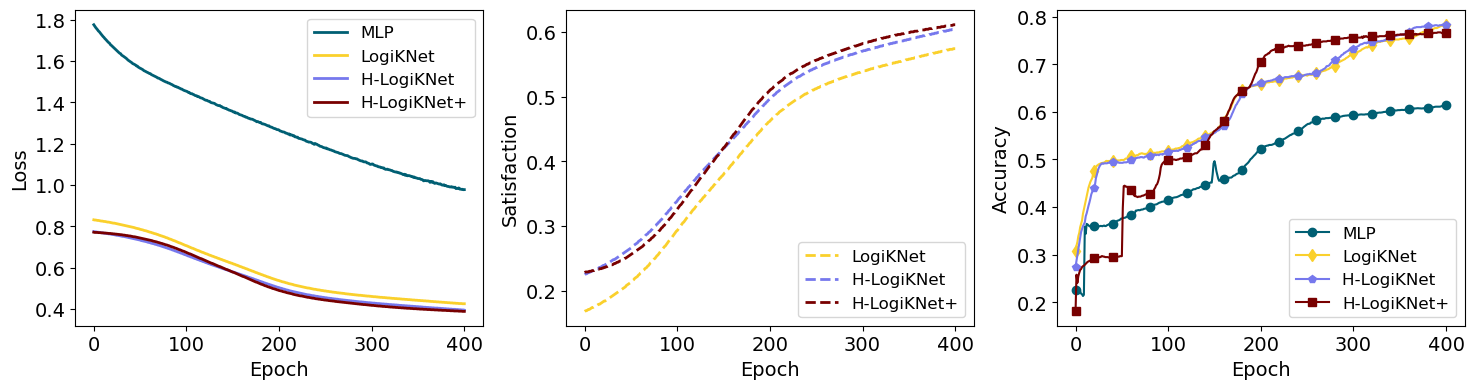

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(mlp_loss, label=plt_config['mlp']['name'], color=plt_config['mlp']['color'], linewidth=line_width)
axs[0].plot(kan_loss, label=plt_config['KL']['name'], color=plt_config['KL']['color'],linewidth=line_width)
axs[0].plot(kan_hierarchical_loss, label=plt_config['KLh']['name'], color=plt_config['KLh']['color'], linewidth=line_width)
axs[0].plot(kan_2layer_loss, label=plt_config['KLh+']['name'], color=plt_config['KLh+']['color'], linewidth=line_width)
axs[0].set_xlabel("Epoch", fontsize=font_size)
axs[0].set_ylabel("Loss", fontsize=font_size)
axs[0].tick_params(axis='both', labelsize=font_size)
axs[0].legend(prop={'size': font_size_axis})

axs[1].plot(kan_sat, label=plt_config['KL']['name'], color=plt_config['KL']['color'], 
            linestyle=line_type['sat']['linestyle'], linewidth=line_width)
axs[1].plot(kan_hierarchical_sat, label=plt_config['KLh']['name'], color=plt_config['KLh']['color'],
            linestyle=line_type['sat']['linestyle'], linewidth=line_width)
axs[1].plot(kan_2layer_sat, label=plt_config['KLh+']['name'], color=plt_config['KLh+']['color'],
            linestyle=line_type['sat']['linestyle'], linewidth=line_width)
axs[1].set_xlabel("Epoch", fontsize=font_size)
axs[1].set_ylabel("Satisfaction", fontsize=font_size)
axs[1].tick_params(axis='both', labelsize=font_size)
axs[1].legend(loc='lower right', prop={'size': font_size_axis})

axs[2].plot(mlp_acc, label=plt_config['mlp']['name'], color=plt_config['mlp']['color'],
            marker=plt_config['mlp']['marker'], markevery=20)
axs[2].plot(kan_acc, label=plt_config['KL']['name'], color=plt_config['KL']['color'],
            marker=plt_config['KL']['marker'], markevery=20)
axs[2].plot(kan_hierarchical_acc, label=plt_config['KLh']['name'], color=plt_config['KLh']['color'],
            marker=plt_config['KLh']['marker'], markevery=20)
axs[2].plot(kan_2layer_acc, label=plt_config['KLh+']['name'], color=plt_config['KLh+']['color'],
            marker=plt_config['KLh+']['marker'], markevery=20)
axs[2].set_xlabel("Epoch", fontsize=font_size)
axs[2].set_ylabel("Accuracy", fontsize=font_size)
axs[2].tick_params(axis='both', labelsize=font_size)
axs[2].legend(prop={'size': font_size_axis})

plt.tight_layout()
# plt.show()
plt.savefig("./output/all-model-performance.pdf", format="pdf", dpi=300)

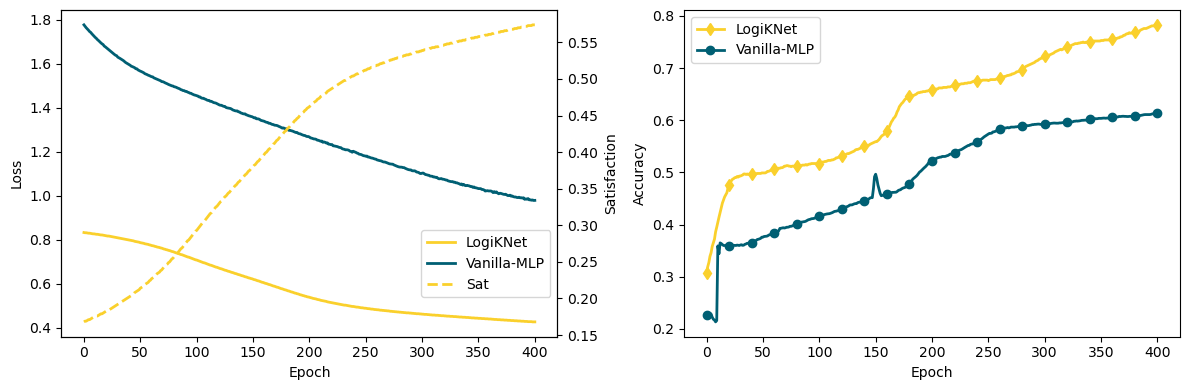

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot Loss on primary y-axis
axs[0].plot(kan_loss, color=plt_config['KL']['color'], label="LogiKNet",
            linestyle=line_type['loss']['linestyle'], linewidth=line_width)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

# Create twin axis for Sat
ax0_twin = axs[0].twinx()
ax0_twin.plot(kan_sat, color=plt_config['KL']['color'], label="Sat",
              linestyle=line_type['sat']['linestyle'], linewidth=line_width)
ax0_twin.set_ylabel("Satisfaction")

axs[0].plot(mlp_loss, color=plt_config['mlp']['color'], label="Vanilla-MLP",
            linestyle=line_type['loss']['linestyle'], linewidth=line_width)

# Combine legends from both axes
lines, labels = axs[0].get_legend_handles_labels()
lines2, labels2 = ax0_twin.get_legend_handles_labels()
axs[0].legend(lines + lines2, labels + labels2, 
              loc="lower right", bbox_to_anchor=(1, 0.1))

# Plot Accuracy on axs[1]
axs[1].plot(kan_acc, color=plt_config['KL']['color'], label="LogiKNet", 
            linewidth=line_width, marker=plt_config['KL']['marker'], markevery=20)
axs[1].plot(mlp_acc, color=plt_config['mlp']['color'], label="Vanilla-MLP", 
            linewidth=line_width, marker=plt_config['mlp']['marker'], markevery=20)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()


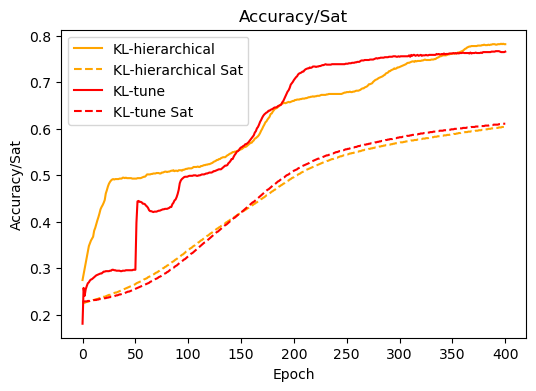

In [ ]:
# Plot the results
with open("KL_hierarchy.txt", "r") as f:
    kan_hierarchical_results = [parse_kan(line) for line in f if line.strip()]

with open("KL_2layer.txt", "r") as f:
	kan_tune_results = [parse_kan(line) for line in f if line.strip()]
	
_, kan_hierarchical_acc, kan_hierarchical_sat = zip(*kan_hierarchical_results)
_, kan_2layer_acc, kan_2layer_sat = zip(*kan_tune_results)

# show acc and sat on same plot
fig, axs = plt.subplots(figsize=(6, 4))
axs.plot(kan_hierarchical_acc, label="KL-hierarchical", color="orange")
axs.plot(kan_hierarchical_sat, label="KL-hierarchical Sat", linestyle="--", color="orange")
axs.plot(kan_2layer_acc, label="KL-tune", color="red")
axs.plot(kan_2layer_sat, label="KL-tune Sat", linestyle="--", color="red")
axs.set_title("Accuracy/Sat")
axs.set_xlabel("Epoch")
axs.set_ylabel("Accuracy/Sat")
axs.legend()
plt.show()